In [55]:
import os
import cv2
import pickle
import numpy as np
import torch

from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from sklearn.metrics.pairwise import cosine_similarity
from facenet_pytorch import InceptionResnetV1, MTCNN

from helper import plot_image_grid

# Specifications

In [56]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
KNOWN_FACES_FILE = "known_faces.pkl"
YOLO_MODEL_PATH = 'models/yolo11n.pt'
FACENET_MODEL = 'vggface2'
IMAGE_SIZE = (160, 160)
SIMILARITY_THRESHOLD = 0.50 
CAMERA_INDEX = 3
FRAME_WIDTH = 640
FRAME_HEIGHT = 480

print(DEVICE)

cuda


# Pre Trained Models

In [57]:
"""These are the pretrained models used in this project"""

yolo_model = YOLO(YOLO_MODEL_PATH).to(DEVICE)
mtcnn = MTCNN(keep_all=True, device=DEVICE)
facenet = InceptionResnetV1(pretrained=FACENET_MODEL).eval().to(DEVICE)

In [58]:
known_faces = {}

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imagenet
])

# Face Detections

In [59]:
def get_embedding(face_image):
    """Calculates a 512 dimensional embedding for each faces"""

    if isinstance(face_image, np.ndarray):
        face_image = Image.fromarray(face_image)
    
    face_image = face_image.convert("RGB")
    face_image = face_image.resize((IMAGE_SIZE))
    face_tensor = transform(face_image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        embedding = facenet(face_tensor)
        print(embedding.shape)
    
    return embedding.cpu().numpy().flatten() 

In [60]:
def save_cropped_faces(image, faces, boxes, save_dir="cropped_faces"):
    """Saves detected face crops as JPG files"""

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_paths = []
    
    if faces and boxes is not None:
        for i, face in enumerate(faces):
            filename = f"{save_dir}/face_{timestamp}_{i}.jpg"
            
            if len(face.shape) == 3 and face.shape[2] == 3:
                face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
            else:
                face_bgr = face
            
            # Save the image
            cv2.imwrite(filename, face_bgr)
            saved_paths.append(filename)
            print(f"Saved face crop to {filename}")
    
    return saved_paths

In [61]:
def detect_face(image, save_crops=False):
    """Locates the coordinate of detected face, crops it, and returns its bounding boxes"""

    if isinstance(image, str):  
        img = cv2.imread(image)  
    else:
        img = image

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, _ = mtcnn.detect(img_rgb)
    # boxes, _ = yolo_model.predict(img_rgb)

    face_list = []
    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img.shape[1], x2), min(img.shape[0], y2)

            if x2 > x1 and y2 > y1:
                face = img_rgb[y1:y2, x1:x2]
                face_list.append(face)
            else:
                print(f"Invalid bounding box detected: {box}")

    if save_crops and face_list:
        save_cropped_faces(img, face_list, boxes)

    return face_list if face_list else None, boxes

In [62]:
def recognize_face(face_image):
    """Calculates the cosine similarity of the face embeddings and returns the best similarity score"""

    face_embedding = get_embedding(face_image)
    
    if not known_faces:
        print("idk who that is")
        return "unknown", 0.0

    best_match = None
    best_score = -1  

    face_embedding = face_embedding / np.linalg.norm(face_embedding)

    for name, stored_embedding in known_faces.items():
        stored_embedding = stored_embedding / np.linalg.norm(stored_embedding)
        similarity = cosine_similarity([face_embedding], [stored_embedding])[0][0]

        if similarity > best_score:
            best_score = similarity
            best_match = name
    
    return (best_match, best_score) if best_score > SIMILARITY_THRESHOLD else ("unknown", best_score)

# Load Embeddings

In [63]:
def load_known_faces():
    """Loads from a saved .pkl file a list of all known faces"""
    
    global known_faces
    try:
        with open(KNOWN_FACES_FILE, "rb") as f:
            known_faces = pickle.load(f)
    except FileNotFoundError:
        known_faces = {}

In [64]:
def save_known_faces():
    """Loads the .pkl file that stores face embeddings"""
    
    with open(KNOWN_FACES_FILE, "wb") as f:
        pickle.dump(known_faces, f)

In [65]:
def add_face(name, image_path):
    """Adds the labled images to list of known faces"""

    faces, _ = detect_face(image_path, save_crops=True)
    
    if faces and len(faces) > 0: 
        face = faces[0]

        if face is None or face.shape[0] == 0 or face.shape[1] == 0:
            print(f"invalid face detected in {image_path}")
            return

        print(f"face resolution: {face.shape}")
        cv2.imshow("detected Face", face)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        face_embedding = get_embedding(face)
        
        if face_embedding is not None:
            known_faces[name] = face_embedding / np.linalg.norm(face_embedding) 
            save_known_faces()
            print(f"added {name} to known faces")
    else:
        print(f"no face detected in {image_path}")


# Facial Recognition

In [66]:
def check_camera(index):
    """Checks if the camera index has a working camera"""

    cap = cv2.VideoCapture(index)
    if not cap.isOpened():
        print(f"camera {index} not detected.")
        return None
    print("Camera exists.")
    return cap

In [67]:
def start_recognition():
    cap = check_camera(CAMERA_INDEX)
    if cap is None:
        return
    
    width, height = 640, 360
    cap.set(cv2.CAP_PROP_FPS, 15)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        faces, detections = detect_face(frame)

        if faces:
            for i, face in enumerate(faces):
                prediction, confidence = recognize_face(face)

                if i < len(detections):
                    x1, y1, x2, y2 = map(int, detections[i][:4])
                    
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    label = f"{prediction} ({confidence:.2f})"
                    
                    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                    cv2.rectangle(frame, (x1, y1 - h - 5), (x1 + w, y1), (0, 0, 255), -1)
                    cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        cv2.imshow("are u my fwend", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [68]:
add_face("yana", "../../data/face-recog/oneshot/yana.jpg")
add_face("jancee", "../../data/face-recog/oneshot/jancee.jpg")
add_face("rheeve", "../../data/face-recog/oneshot/rheeve.jpg")
add_face("rico", "../../data/face-recog/oneshot/rico.jpg")
add_face("gerard", "../../data/face-recog/oneshot/gerard.jpg")
add_face("catherine", "../../data/face-recog/oneshot/catherine.jpg")
add_face("lorenz", "../../data/face-recog/oneshot/lorenz.jpg")
add_face("jesli", "../../data/face-recog/oneshot/jesli.jpg")


Saved face crop to cropped_faces/face_20250404_225857_0.jpg
face resolution: (875, 510, 3)
torch.Size([1, 512])
added yana to known faces
Saved face crop to cropped_faces/face_20250404_225901_0.jpg
face resolution: (1167, 938, 3)
torch.Size([1, 512])
added jancee to known faces
Saved face crop to cropped_faces/face_20250404_225903_0.jpg
face resolution: (387, 310, 3)
torch.Size([1, 512])
added rheeve to known faces
Saved face crop to cropped_faces/face_20250404_225905_0.jpg
face resolution: (628, 507, 3)
torch.Size([1, 512])
added rico to known faces
Saved face crop to cropped_faces/face_20250404_225907_0.jpg
face resolution: (937, 685, 3)
torch.Size([1, 512])
added gerard to known faces
Saved face crop to cropped_faces/face_20250404_225908_0.jpg
Saved face crop to cropped_faces/face_20250404_225908_1.jpg
face resolution: (1413, 1017, 3)
torch.Size([1, 512])
added catherine to known faces
Saved face crop to cropped_faces/face_20250404_225910_0.jpg
Saved face crop to cropped_faces/face_

In [69]:
if __name__ == "__main__":
    load_known_faces()
    start_recognition()

Camera exists.


# Known Faces

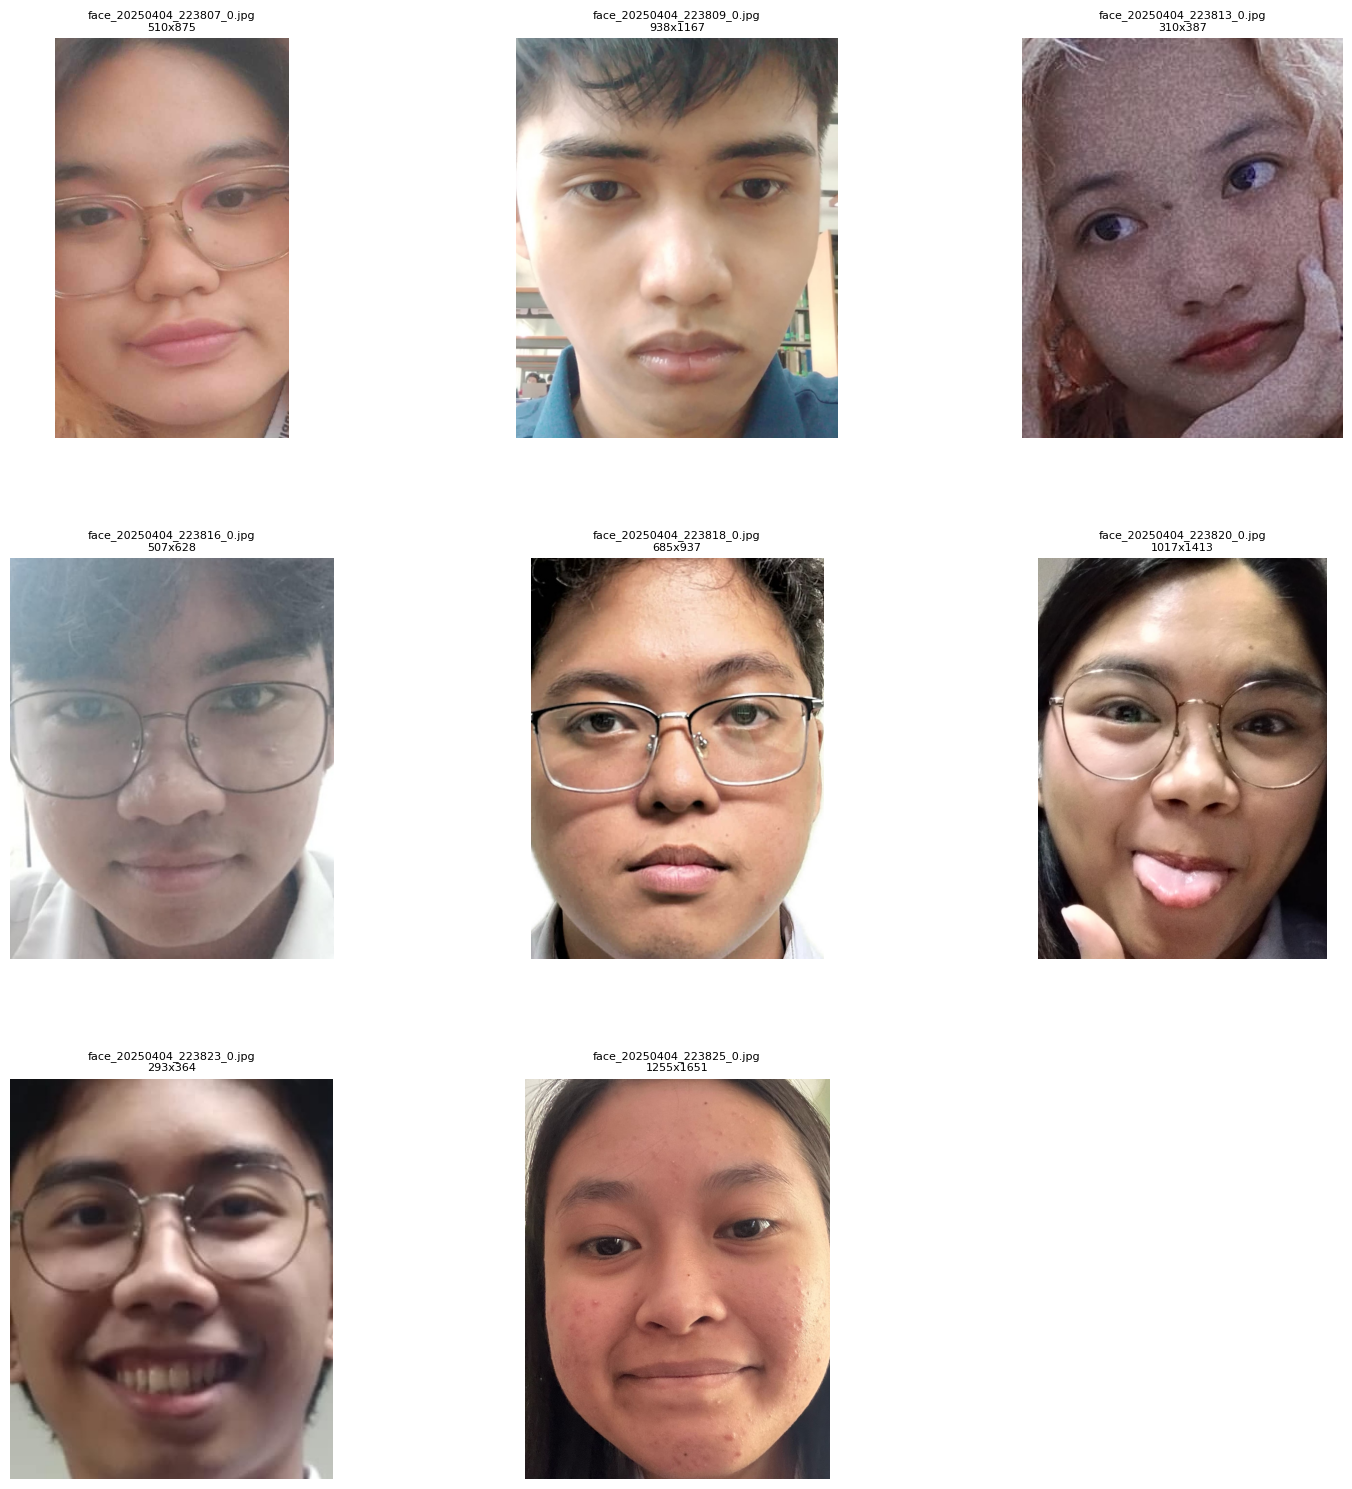

In [72]:
plot_image_grid('cropped_faces')